# 19F NMR screening hit : molecular property calculation and analysis
## S. Ruedisser 2025

In [22]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

import seaborn as sns
sns.set(style = 'whitegrid') 
 
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools, Draw
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol

from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem import Descriptors
from IPython.display import HTML


import warnings
warnings.filterwarnings('ignore')

## Screening library

In [4]:
# Read excel file with molecular properties of the library compounds (KNIME FHit_analysis)
data = pd.read_excel("../doc/HIT_analysis/library_properties.xlsx")

# exclude Synple compounds
data = data[data["set"] != "Synple"]

In [5]:
# add column True if CF3 
CF3 = Chem.MolFromSmiles("C(F)(F)(F)")
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule',includeFingerprints=True)
data["CF3"] = (data["Molecule"] >= CF3)
data.head()

,cpd code,smiles,set,Salt Stripped Molecule,SlogP,LabuteASA,TPSA,AMW,ExactMW,NumRotatableBonds,NumHBD,NumHBA,NumAromaticRings,FractionCSP3,Molecule,CF3
0,BNC-ABL004-NS-1,CN1N=CC=2C(NC=3C=CC(OC(F)(F)F)=CC3)=NC=NC12,hit,Cn1ncc2c(Nc3ccc(OC(F)(F)F)cc3)ncnc21,3.0055,122.106589,64.86,309.251,309.083745,3,1,6,3,0.153846,<rdkit.Chem.rdchem.Mol object at 0x7f809e986030>,True
1,BNC-TRY013-NS-1,C1=CC2=C(C=C1C(F)(F)F)NN=C2N,hit,Nc1n[nH]c2cc(C(F)(F)F)ccc12,2.1639,76.711769,54.70,201.151,201.051382,0,2,2,2,0.125000,<rdkit.Chem.rdchem.Mol object at 0x7f809e985f50>,True
2,BNC-TFL067-NS-1,Nc1ncc(C(F)(F)F)cc1Cl,hit,Nc1ncc(C(F)(F)F)cc1Cl,2.3360,71.155756,38.91,196.559,196.001510,0,1,2,1,0.166667,<rdkit.Chem.rdchem.Mol object at 0x7f809e985e00>,True
3,BNC-TFL071-Cl-1,O=c1[nH]c2cc(C(F)(F)F)ccc2n1C1CCNCC1,hit,O=c1[nH]c2cc(C(F)(F)F)ccc2n1C1CCNCC1,2.2729,112.143660,49.82,285.269,285.108897,1,2,3,2,0.461538,<rdkit.Chem.rdchem.Mol object at 0x7f809e985d20>,True
4,BNC-TFL145-NS-1,COc1ccc(S(=O)(=O)Nc2nc(C(F)(F)F)cs2)cc1,hit,COc1ccc(S(=O)(=O)Nc2nc(C(F)(F)F)cs2)cc1,2.9713,121.999182,68.29,338.332,338.000669,4,1,5,2,0.181818,<rdkit.Chem.rdchem.Mol object at 0x7f809e985cb0>,True


In [7]:
# keep only relevant properties
data = data[["set", "SlogP", "NumHBD", "NumHBA", "FractionCSP3", "TPSA", "NumRotatableBonds", "NumAromaticRings", "ExactMW"]]

# calculate mean values
data_mean = data.groupby(["set"]).mean().loc[["CF","CF3","hit"]]
data_std = data.groupby(["set"]).std().loc[["CF","CF3","hit"]]
data_mean.head()

,SlogP,NumHBD,NumHBA,FractionCSP3,TPSA,NumRotatableBonds,NumAromaticRings,ExactMW
set,,,,,,,,
CF,1.876947,0.946479,2.656338,0.235131,46.707239,2.008451,1.580282,227.037093
CF3,2.024293,1.106299,3.188976,0.380193,52.805315,1.917323,1.314961,256.521496
hit,2.039162,1.025000,3.037500,0.289987,46.103000,1.937500,1.637500,237.393873


In [9]:
# calculate mean values for CF subsets with various numbers of HBD
data[data["set"] == "CF"].groupby(["NumHBD"]).count()

,set,SlogP,NumHBA,FractionCSP3,TPSA,NumRotatableBonds,NumAromaticRings,ExactMW
NumHBD,,,,,,,,
0,87,87,87,87,87,87,87,87
1,202,202,202,202,202,202,202,202
2,64,64,64,64,64,64,64,64
3,2,2,2,2,2,2,2,2


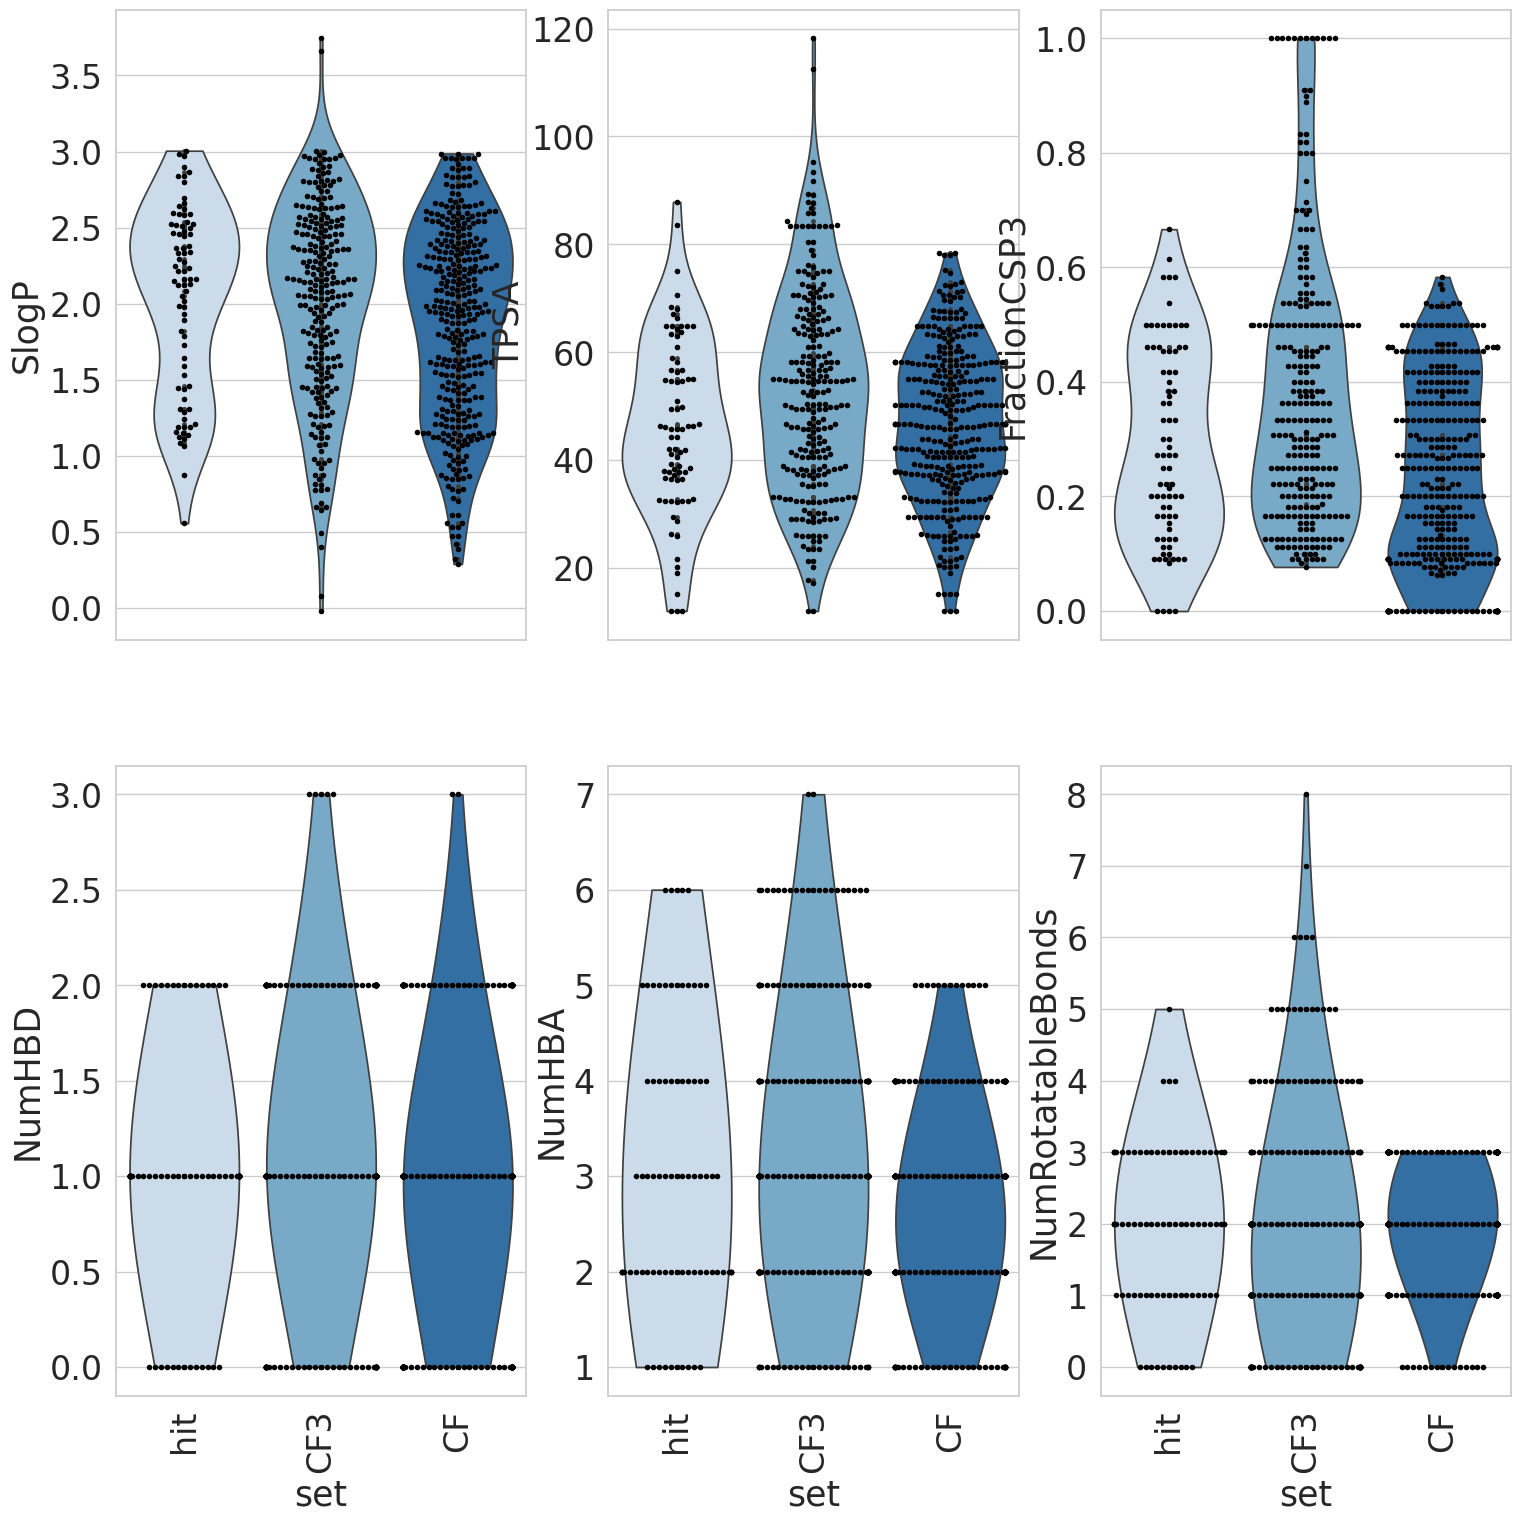

In [10]:
# Violin plot for library properties

rcParams['figure.figsize'] = 18, 18
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['xtick.direction'] = "out"

mpl.rcParams['ytick.labelsize'] = 24

fig, axes = plt.subplots(2, 3, sharex=True)

width = 0.8
size = 4
bw_adjust = 3


plotSlogP = sns.violinplot(x = "set" , y = "SlogP", data = data, width = width, cut = 0, inner="points", palette="Blues", ax=axes[0,0])
sns.swarmplot(x = "set" , y = "SlogP", data = data, color = "black", size = size, ax=axes[0,0])


plotTPSA = sns.violinplot(x = "set" , y = "TPSA" , data = data, width = width, cut=0, inner="points", palette="Blues", ax=axes[0, 1])
sns.swarmplot(x = "set" , y = "TPSA" , data = data,color= "black", size=size, ax=axes[0, 1])

plotSP3 = sns.violinplot(x = "set" , y = "FractionCSP3", data = data, width = width, cut = 0, inner="points", palette="Blues", ax=axes[0,2])
sns.swarmplot(x = "set" , y = "FractionCSP3", data = data,color = "black", size = size, ax=axes[0,2])


plotHBD = sns.violinplot(x = "set" , y = "NumHBD" , data = data, width = width, bw_adjust = bw_adjust, cut=0, inner="points", palette="Blues", ax=axes[1, 0])
sns.swarmplot(x = "set" , y = "NumHBD" , data = data,color= "black", dodge=True, size=size,  ax=axes[1, 0])

plotHBA = sns.violinplot(x = "set" , y = "NumHBA" , data = data, width = width, bw_adjust = bw_adjust, cut=0, inner="points", palette="Blues", ax=axes[1, 1])
sns.swarmplot(x = "set" , y = "NumHBA" , data = data,color= "black", size=size, ax=axes[1, 1])

plotNumRotatableBonds = sns.violinplot(x = "set" , y = "NumRotatableBonds" , data = data, width = width, bw_adjust = bw_adjust, cut=0, inner="points", palette="Blues", ax=axes[1, 2])
sns.swarmplot(x = "set" , y = "NumRotatableBonds" , data = data,color= "black", size=size, ax=axes[1, 2])


plt.setp(plotSlogP.get_xticklabels(), rotation=90)
plt.setp(plotSP3.get_xticklabels(), rotation=90)
plt.setp(plotTPSA.get_xticklabels(), rotation=90)
plt.setp(plotHBD.get_xticklabels(), rotation=90)
plt.setp(plotHBA.get_xticklabels(), rotation=90)
#plt.setp(plotNumAromaticRings.get_xticklabels(), rotation=90)
plt.setp(plotNumRotatableBonds.get_xticklabels(), rotation=90)
#plt.setp(plotExactMW.get_xticklabels(), rotation=90)

plt.savefig("library_analysis.svg")

## Hit analysis

In [11]:
# Read excel file with molecular properties of the library compounds (KNIME FHit_analysis)
data = pd.read_excel("../doc/HIT_analysis/hits_properties.xlsx")
data.columns

Index(['CPD code', 'Smiles', 'target', 'Salt Stripped Molecule', 'SlogP',
       'SMR', 'LabuteASA', 'TPSA', 'AMW', 'ExactMW', 'NumLipinskiHBA',
       'NumLipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA',
       'NumAmideBonds', 'NumHeteroAtoms', 'NumHeavyAtoms', 'NumAtoms',
       'NumStereocenters', 'NumUnspecifiedStereocenters', 'NumRings',
       'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings',
       'NumAromaticHeterocycles', 'NumSaturatedHeterocycles',
       'NumAliphaticHeterocycles', 'NumAromaticCarbocycles',
       'NumSaturatedCarbocycles', 'NumAliphaticCarbocycles', 'FractionCSP3'],
      dtype='object')

In [12]:
# add column True if CF3 is in molecule
CF3 = Chem.MolFromSmiles("C(F)(F)(F)")
PandasTools.AddMoleculeColumnToFrame(data,'Smiles','Molecule',includeFingerprints=True)
data["CF3"] = (data["Molecule"] >= CF3)
data["CF3"].value_counts()

CF3
False    62
True     30
Name: count, dtype: int64

In [13]:
# keep only relevant properties
data = data[["target", "SlogP", "NumHBD", "NumHBA", "NumAromaticRings", "FractionCSP3", "TPSA", "ExactMW", "NumRotatableBonds","CF3"]]

# calculate mean values for each target
data_mean = data.groupby(["target"]).mean()
data_std = data.groupby(["target"]).std()
data_mean

,SlogP,NumHBD,NumHBA,NumAromaticRings,FractionCSP3,TPSA,ExactMW,NumRotatableBonds,CF3
target,,,,,,,,,
FKBP12,1.868000,0.500000,3.000000,1.250000,0.390271,54.367500,286.591642,2.750000,0.250000
LecA,2.515047,1.000000,2.833333,2.000000,0.175641,46.481667,237.404830,2.500000,0.000000
LecB,2.333850,0.500000,2.500000,1.000000,0.500000,48.010000,282.621099,3.000000,0.000000
Mpro,2.391098,1.181818,3.363636,1.818182,0.269787,52.114545,256.699457,1.272727,1.000000
NCTD,1.736328,0.800000,3.400000,1.800000,0.191313,52.606000,223.265992,1.600000,0.200000
PPAT,2.209832,1.000000,4.300000,1.800000,0.328129,57.608000,274.670562,2.300000,1.000000
RNA,2.413348,1.000000,4.600000,2.000000,0.445105,49.558000,301.130403,2.200000,1.000000
SRSF1,2.255904,1.200000,3.400000,2.200000,0.195657,52.498000,232.260090,2.200000,0.200000
WDR5,2.228243,0.916667,2.833333,1.750000,0.196858,43.873333,237.227120,1.500000,0.083333


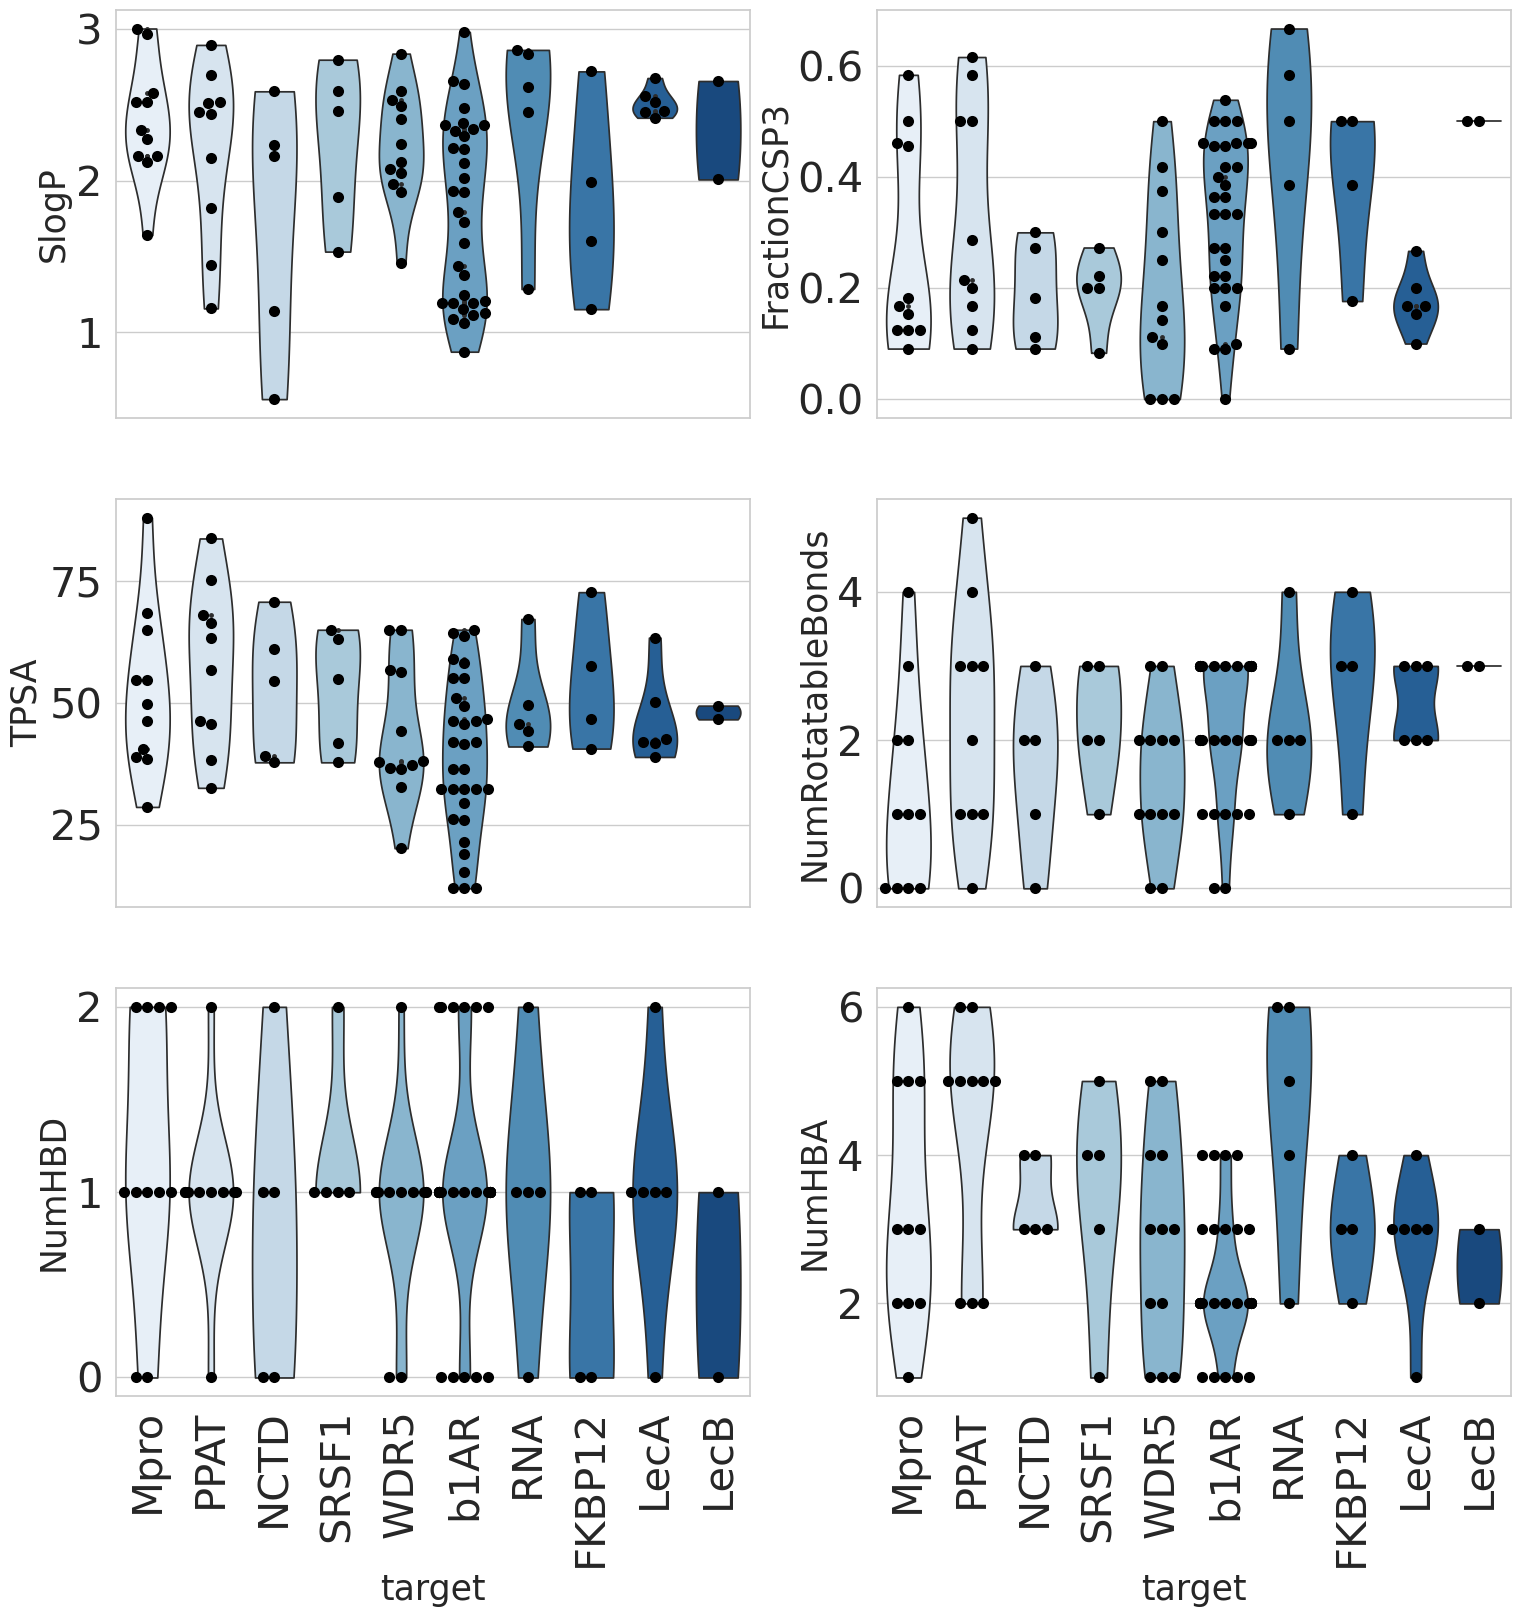

In [14]:
# Violin plot with hit properties

rcParams['figure.figsize'] = 18, 18
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['xtick.direction'] = "out"

mpl.rcParams['ytick.labelsize'] = 30

width = 0.7

fig, axes = plt.subplots(3, 2, sharex=True)

plotSlogP = sns.violinplot(x = "target" , y = "SlogP", data = data, width = width, cut = 0, inner="points", palette="Blues", ax=axes[0, 0])
sns.swarmplot(x = "target" , y = "SlogP", data = data, color = "black", size = 8, ax=axes[0, 0])

plotSP3 = sns.violinplot(x = "target" , y = "FractionCSP3", data = data, width = width, cut = 0, inner="points",palette="Blues", ax=axes[0, 1])
sns.swarmplot(x = "target" , y = "FractionCSP3", data = data,color = "black", size = 8, ax=axes[0, 1])

plotTPSA = sns.violinplot(x = "target" , y = "TPSA" , data = data, width=width, cut=0, inner="points", palette="Blues", ax=axes[1, 0])
sns.swarmplot(x = "target" , y = "TPSA" , data = data,color= "black", size=8, ax=axes[1, 0])

plotNumRotatableBonds = sns.violinplot(x = "target" , y = "NumRotatableBonds" , data = data, width=width, cut=0, inner="points", palette="Blues", ax=axes[1, 1])
sns.swarmplot(x = "target" , y = "NumRotatableBonds" , data = data,color= "black", size=8, ax=axes[1, 1])

plotHBD = sns.violinplot(x = "target" , y = "NumHBD" , data = data, width=width, cut=0, inner="points", palette="Blues", ax=axes[2, 0])
sns.swarmplot(x = "target" , y = "NumHBD" , data = data,color= "black", size=8,  ax=axes[2, 0])

plotHBA = sns.violinplot(x = "target" , y = "NumHBA" , data = data, width = width, cut=0, inner="points", palette="Blues", ax=axes[2, 1])
sns.swarmplot(x = "target" , y = "NumHBA" , data = data,color= "black", size=8, ax=axes[2, 1])


plt.setp(plotSlogP.get_xticklabels(), rotation=90)
plt.setp(plotSP3.get_xticklabels(), rotation=90)
plt.setp(plotHBD.get_xticklabels(), rotation=90)
plt.setp(plotHBA.get_xticklabels(), rotation=90)
#plt.setp(plotNumAromaticRings.get_xticklabels(), rotation=90)
plt.setp(plotNumRotatableBonds.get_xticklabels(), rotation=90)
plt.setp(plotTPSA.get_xticklabels(), rotation=90)
#plt.setp(plotExactMW.get_xticklabels(), rotation=90)

plt.savefig("hits_analysis.svg")

## Clustering of structures

In [26]:
def butina_cluster(mol_list,cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

In [16]:
# Read table with hits and molecular properties
hits = pd.read_excel("../doc/HIT_analysis/hits_properties.xlsx")
hits.head()

,CPD code,Smiles,target,Salt Stripped Molecule,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,...,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3
0,BNC-ABL004-NS-1,CN1N=CC=2C(NC=3C=CC(OC(F)(F)F)=CC3)=NC=NC12,Mpro,Cn1ncc2c(Nc3ccc(OC(F)(F)F)cc3)ncnc21,3.0055,72.7117,122.106589,64.86,309.251,309.083745,...,3,0,0,2,0,0,1,0,0,0.153846
1,BNC-TRY013-NS-1,C1=CC2=C(C=C1C(F)(F)F)NN=C2N,Mpro,Nc1n[nH]c2cc(C(F)(F)F)ccc12,2.1639,45.5081,76.711769,54.70,201.151,201.051382,...,2,0,0,1,0,0,1,0,0,0.125000
2,BNC-TFL067-NS-1,Nc1ncc(C(F)(F)F)cc1Cl,Mpro,Nc1ncc(C(F)(F)F)cc1Cl,2.3360,38.6614,71.155756,38.91,196.559,196.001510,...,1,0,0,1,0,0,0,0,0,0.166667
3,BNC-TFL071-Cl-1,O=c1[nH]c2cc(C(F)(F)F)ccc2n1C1CCNCC1,Mpro,O=c1[nH]c2cc(C(F)(F)F)ccc2n1C1CCNCC1,2.2729,68.7014,112.143660,49.82,285.269,285.108897,...,2,1,1,1,1,1,1,0,0,0.461538
4,BNC-TFL145-NS-1,COc1ccc(S(=O)(=O)Nc2nc(C(F)(F)F)cs2)cc1,Mpro,COc1ccc(S(=O)(=O)Nc2nc(C(F)(F)F)cs2)cc1,2.9713,70.9185,121.999182,68.29,338.332,338.000669,...,2,0,0,1,0,0,1,0,0,0.181818


In [17]:
# show targets
list(set(hits["target"]))

['LecA',
 'FKBP12',
 'SRSF1',
 'Mpro',
 'WDR5',
 'b1AR',
 'RNA',
 'LecB',
 'PPAT',
 'NCTD']

In [28]:
# for each target, perform butina clustering
target_nr = 4
cutoff = 0.90 # higher cutoff gives fewer cluster

target = list(set(hits["target"]))[target_nr]
print(target)

hits_target = hits.loc[(hits["target"] == target)]

PandasTools.AddMoleculeColumnToFrame(hits_target,smilesCol="Smiles")

%time hits_target['Cluster'] = butina_cluster(hits_target.ROMol.values, cutoff=cutoff)
print("number of clusters: " + str(len(list(set(hits_target['Cluster'])))))
print("number of hits: " + str(hits_target.shape[0]))
cluster = butina_cluster(hits_target.ROMol.values, cutoff=cutoff)
print("cluster ID, number of members")
print(str([[x,cluster.count(x)] for x in set(cluster)]))

WDR5
CPU times: user 873 µs, sys: 0 ns, total: 873 µs
Wall time: 836 µs
number of clusters: 2
number of hits: 12
cluster ID, number of members
[[1, 10], [2, 2]]


In [31]:
set(cluster)

{1, 2}

In [30]:
# for each cluster, write svg file with molecular structures

for cluster_nr in set(cluster):
    #cluster_nr = 1
    mols = hits_target[(hits_target["target"] == target) & (hits_target["Cluster"] == cluster_nr)]["Smiles"]
    molsChem = [Chem.MolFromSmiles(mol) for mol in mols]
    
    cur_scaf_df = hits_target[hits_target["Cluster"]==cluster_nr]
    #mol_scaffold_of_interest = Chem.MolFromSmiles(cur_scaf_smiles)
    
    #custom_legend = [' : '.join(tup) for tup in list(zip(cur_scaf_df['CPD code'], cur_scaf_df['target'].astype(str)))]
    custom_legend = list(cur_scaf_df['CPD code'])
    
    #cur_scaf_smiles = Chem.MolToSmiles(Chem.MolFromSmarts(MCS.FindMCS(list(molsChem),threshold=0.7).smarts))    
    #highlight_scaffold = [mMol.GetSubstructMatch(Chem.MolFromSmiles(cur_scaf_smiles)) for mMol in cur_scaf_df['ROMol']]
    
    img = Draw.MolsToGridImage(cur_scaf_df['ROMol'], 
                         legends = custom_legend,
                         #highlightAtomLists = highlight_scaffold, 
                         molsPerRow=4,
                         subImgSize=(300,300), useSVG=True)
    
    outfolder = "/home/Simon/Documents/BNSP/projects/FBS/publication/molimage/"
    outfile = outfolder + str(list(set(hits["target"]))[target_nr]) + "_" + str(cluster_nr) + ".svg"
    with open(outfile, 'w') as f:
        f.write(img.data)
    img

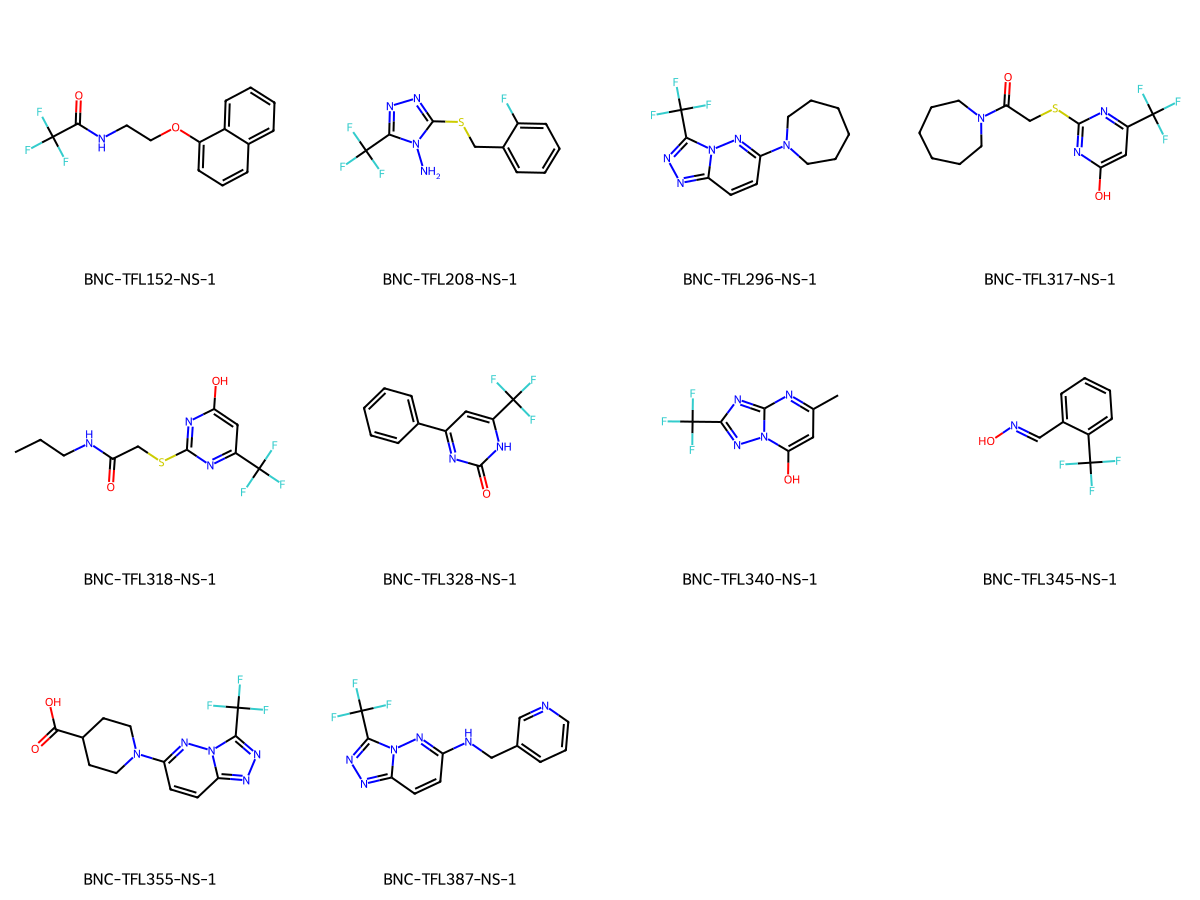

In [23]:
img